In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from lightgbm import LGBMClassifier

In [3]:
dataset = pd.read_csv('../Datasets/Churn_Modelling.csv')
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
X = dataset.iloc[:, 3:13].values
y = dataset.iloc[:, 13].values

In [5]:
labelencoder_X_1 = LabelEncoder()
X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])
labelencoder_X_2 = LabelEncoder()
X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])
onehotencoder = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), [1])],   
    remainder='passthrough'
)
X = onehotencoder.fit_transform(X)
X = X[:, 1:]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
classifier = LGBMClassifier().fit(X_train, y_train)
y_pred = classifier.predict(X_test)

[LightGBM] [Info] Number of positive: 1632, number of negative: 6368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.204000 -> initscore=-1.361479
[LightGBM] [Info] Start training from score -1.361479


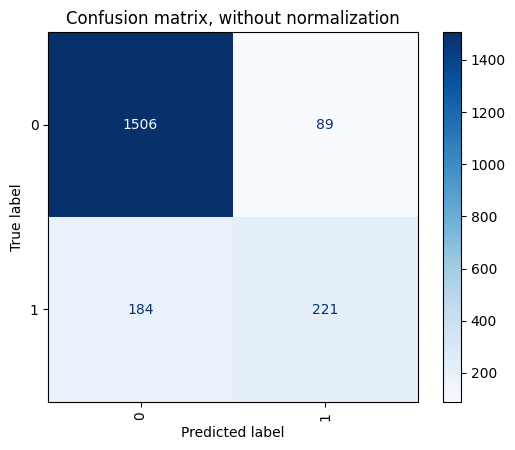

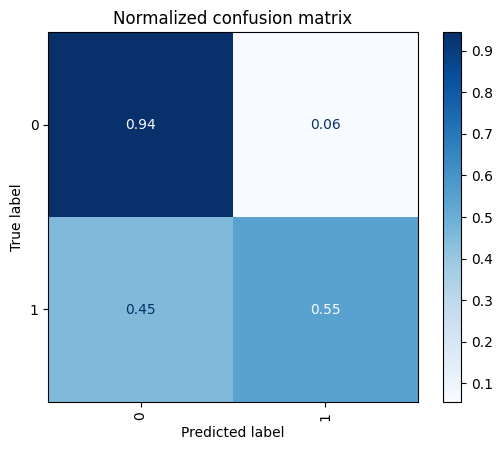

In [8]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
cm = confusion_matrix(y_test, y_pred)
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    
    if normalize:
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=classifier.classes_)
    
    disp.plot(cmap=plt.cm.Blues, values_format='.2f' if normalize else 'd', xticks_rotation='vertical')
    plt.title(title)
    plt.show()

In [9]:
cv_scores = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10)
cv_scores

[LightGBM] [Info] Number of positive: 1469, number of negative: 5731
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.204028 -> initscore=-1.361308
[LightGBM] [Info] Start training from score -1.361308
[LightGBM] [Info] Number of positive: 1469, number of negative: 5731
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.204028 -> initscore=-1.361308
[LightGBM]

array([0.87375, 0.84875, 0.875  , 0.85125, 0.84875, 0.86125, 0.8725 ,
       0.85125, 0.84125, 0.86875])

In [10]:
print("cv_scores mean: {}".format(np.mean(cv_scores)))
print("cv_scores std: {}".format(np.std(cv_scores)))

cv_scores mean: 0.8592500000000001
cv_scores std: 0.011834800378544634


In [12]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7449398196524634

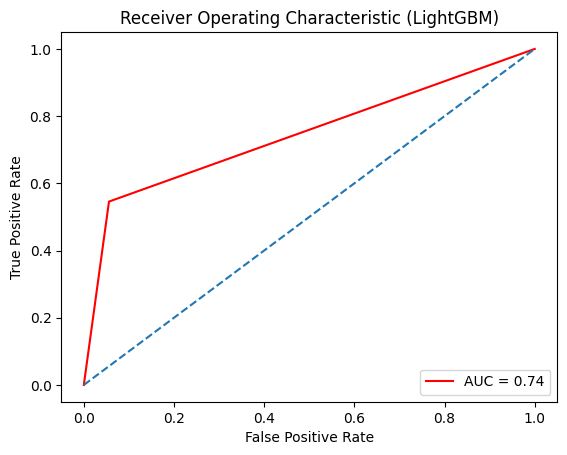

In [11]:

plt.title('Receiver Operating Characteristic (LightGBM)')
plt.plot(false_positive_rate, true_positive_rate, color='red', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()